POTATO DISEASE LEAF

`01` Import Libraries 

In [1]:
import pandas as pd  
import numpy as  np  
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
from numpy import random

import seaborn as sns
%matplotlib inline

In [25]:
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


`02` Global Variables

In [17]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

NUM_SAMPLES = 4

`03` Read Data

In [18]:
data_dir = '/home/israa/Desktop/Computer_Vision_Projects/01-Potato_Disease_Leaf/PLD_3_Classes_256'

# Update train_dir to use an absolute path
early_bight_path = healthy_bath = os.path.join(data_dir, 'Training/Early_Blight')
healthy_bath = os.path.join(data_dir, 'Training/Healthy')
late_bight_path = os.path.join(data_dir, 'Training/Late_Blight')

early_train_files = [os.path.join(early_bight_path, filename) for filename in os.listdir(early_bight_path)]
healthy_train_files = [os.path.join(healthy_bath, filename) for filename in os.listdir(healthy_bath)]
late_train_files = [os.path.join(late_bight_path, filename) for filename in os.listdir(late_bight_path)]


`04` Simple EDA

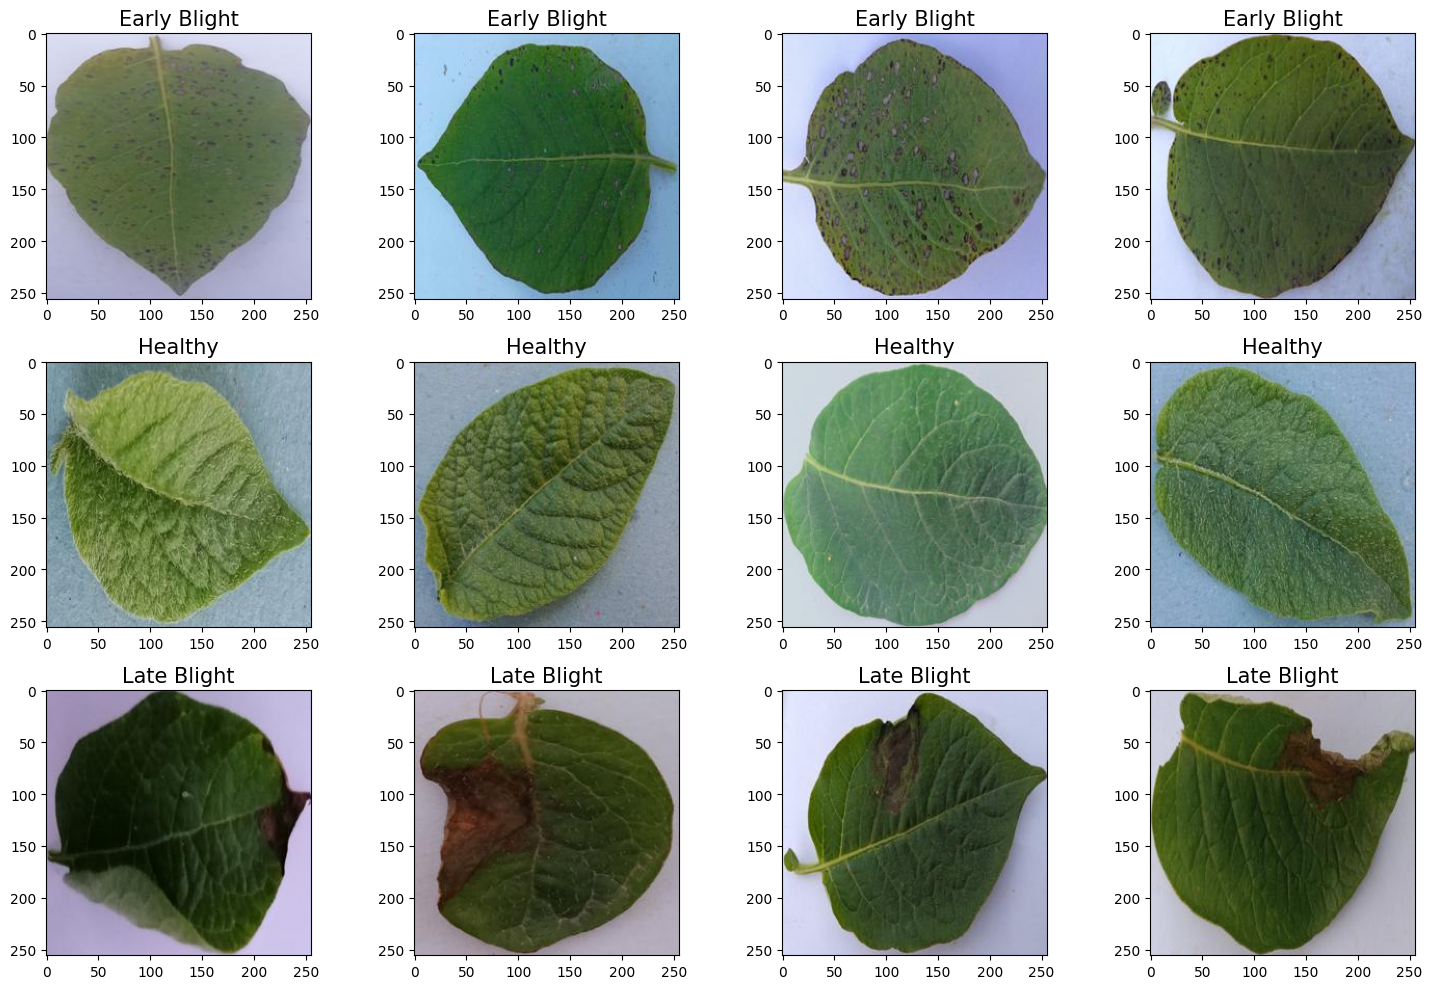

In [22]:
# Create subplots for displaying images
fig, axes = plt.subplots(3, NUM_SAMPLES, figsize=(15, 10))

# Displaying Early Blight images
early_sample = random.choice(early_train_files, NUM_SAMPLES, replace=False)
for i, image_path in enumerate(early_sample):
    ax = axes[0, i]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title('Early Blight', fontsize=15)  
    ax.axis('on')  # Show axis


# Displaying Healthy images
healthy_sample = random.choice(healthy_train_files, NUM_SAMPLES, replace=False)
for i, image_path in enumerate(healthy_sample):
    ax = axes[1, i]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title('Healthy', fontsize=15)  
    ax.axis('on')  # Show axis

# Displaying Late Blight images
late_sample = random.choice(late_train_files, NUM_SAMPLES, replace=False)
for i, image_path in enumerate(late_sample):
    ax = axes[2, i]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title('Late Blight', fontsize=15)  
    ax.axis('on')  # Show axis


plt.tight_layout()  

`05` Preprocessing

### Rescaling Images for Better Training Performance

Rescaling the images by dividing pixel values by 255 (i.e., `rescale=1./255`) is a **normalization** technique that helps simplify the image matrices.

### Why is this helpful?

*   **Pixel Value Range**: The original pixel values in an image range from 0 to 255. By dividing by 255, you're scaling the pixel values to a range between **0 and 1**.
    
*   **Improved Model Training**: Neural networks generally perform better and converge faster when the input data is normalized, because:
    
    *   It helps the optimizer converge more quickly (gradient descent works better with smaller, consistent values).
        
    *   It reduces the risk of numerical instability during training.
        
    *   It makes training more efficient by ensuring that each input feature (pixel) has similar scales.

### In Short:

*   **Rescaling** doesn't "simplify" the images in terms of content, but it **simplifies the data** by making the numerical values more manageable and consistent. This leads to **faster training** and **more stable training dynamics**.


In [27]:
# 1. Create ImageDataGenerator objects for training, validation, and testing
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [28]:
# 2. Create generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'Training'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(os.path.join(data_dir, 'Validation'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(os.path.join(data_dir, 'Testing'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3251 images belonging to 3 classes.
Found 416 images belonging to 3 classes.
Found 405 images belonging to 3 classes.
{'Early_Blight': 0, 'Healthy': 1, 'Late_Blight': 2}
Number of classes: 3


In [39]:
# 3. Check the class indices
print("Class Index Mapping:", train_generator.class_indices)

# 4. Check the number of classes
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)

# 5. Check the number of samples in each generator
print("Number of training samples:", len(train_generator.filenames))
print("Number of validation samples:", len(valid_generator.filenames))
print("Number of testing samples:", len(test_generator.filenames))


Class Index Mapping: {'Early_Blight': 0, 'Healthy': 1, 'Late_Blight': 2}
Number of classes: 3
Number of training samples: 3251
Number of validation samples: 416
Number of testing samples: 405


In [40]:
# 6. Check the shape of the images
sample_image, sample_label = next(train_generator)
print("Shape of sample image:", sample_image.shape)

# 7. Check the shape of the labels
print("Shape of sample label:", sample_label.shape)

# The sample is the size of the batch, which is 32 in this case.

Shape of sample image: (32, 256, 256, 3)
Shape of sample label: (32, 3)


In [34]:
# 8. Check the class distribution in the training set
class_counts = np.bincount(train_generator.classes)
class_distribution = dict(zip(train_generator.class_indices.keys(), class_counts))
print("Class distribution in training set:", class_distribution)


Class distribution in training set: {'Early_Blight': 1303, 'Healthy': 816, 'Late_Blight': 1132}


`06` Data Visualization 

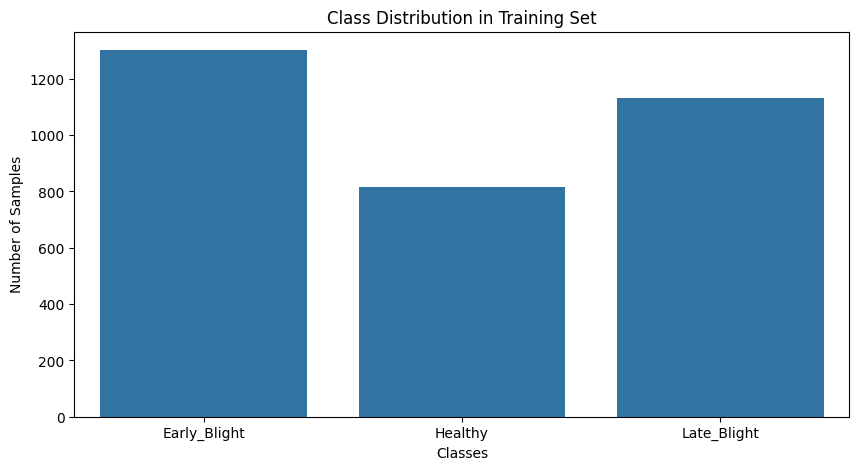

In [36]:
# 9. Visualize the class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.title('Class Distribution in Training Set')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.show()

The data is quiete balanced

remember that we have used a generator for the train data 

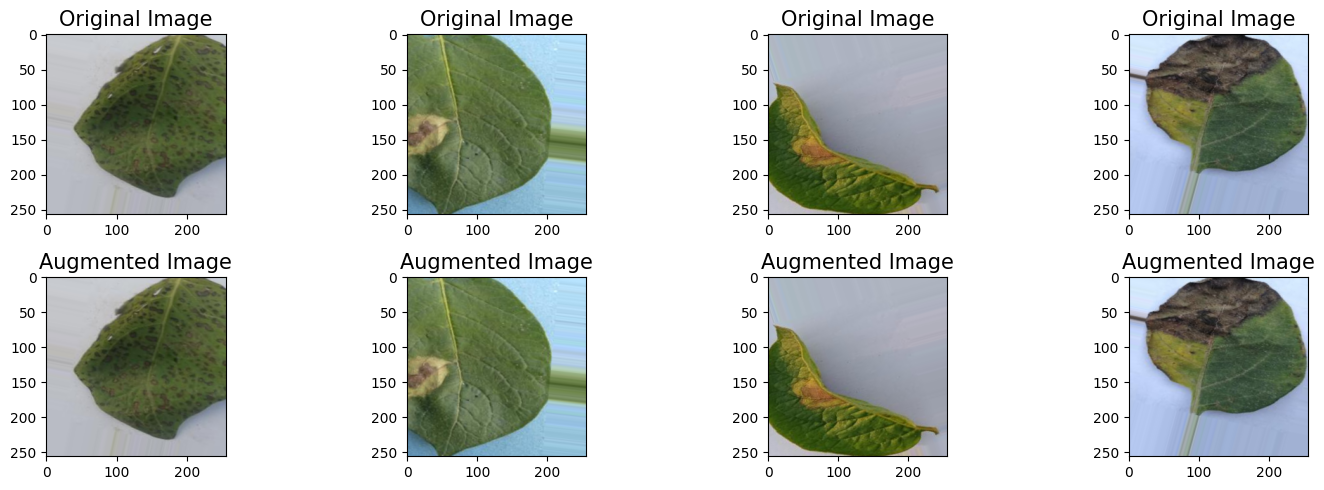

In [37]:
# 10. Visualize some augmented images vs original images
sample_images, sample_labels = next(train_generator)

# Create subplots for displaying images
fig, axes = plt.subplots(2, NUM_SAMPLES, figsize=(15, 5))

# Displaying original images
for i in range(NUM_SAMPLES):
    ax = axes[0, i]
    img = sample_images[i]
    ax.imshow(img)
    ax.set_title('Original Image', fontsize=15)  
    ax.axis('on')  # Show axis

# Displaying augmented images
for i in range(NUM_SAMPLES):
    ax = axes[1, i]
    img = sample_images[i]
    ax.imshow(img)
    ax.set_title('Augmented Image', fontsize=15)  
    ax.axis('on')  # Show axis

plt.tight_layout()
